In [1]:
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [2]:
cwd = os.getcwd()
output_dir = os.path.join(cwd, "../../data")
df = pd.read_csv(os.path.join(output_dir, "combined_sentimentanalysis.csv"))
df_test = pd.read_csv(os.path.join(output_dir, "combined_sentimentanalysistest.csv"))
#df_test = pd.read_csv(os.path.join(output_dir, "figlet1599056546.006096_1599063766.431225.csv"))
df = df.drop(df[df.responsetime > 2].index)
df.pop('Time')
df_test = df_test.drop(df_test[df_test.responsetime > 2].index)
df_test.pop('Time')
df.head()

,cpu,diskio,diskioRead,diskioWritten,mem,networkReceived,networkTransmitted,replica,requests,responsetime,totalcpu,totalcpuUtilization,totalmemory,totalmemoryUtilization
0,7.452470,0.000129,0.000000,1.484572e+04,0.006211,7.686411e+02,690.618472,1.0,7.0,0.427801,12.0,76.330988,5.045532e+10,10.168922
1,6.314931,0.056578,903.680000,7.635895e+06,0.006211,4.423151e+06,44196.825694,1.0,42.0,0.441701,12.0,76.330988,5.045532e+10,10.168922
2,9.499113,0.073244,1001.244444,9.543407e+06,0.006211,4.011359e+06,41064.000000,1.0,76.0,0.429230,12.0,13.216667,5.045532e+10,10.329697
3,6.085528,0.073156,1001.244444,9.533212e+06,0.026095,4.012145e+06,42053.311111,1.0,112.0,0.421655,12.0,13.216667,5.045532e+10,10.329697
4,9.452724,0.021956,182.044444,2.628813e+06,0.119376,3.909378e+03,3469.288889,1.0,140.0,0.439443,12.0,14.213889,5.045532e+10,10.159327


In [3]:
# remove 2xlarge
df = df.drop(df[df.totalcpu > 16].index)

/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


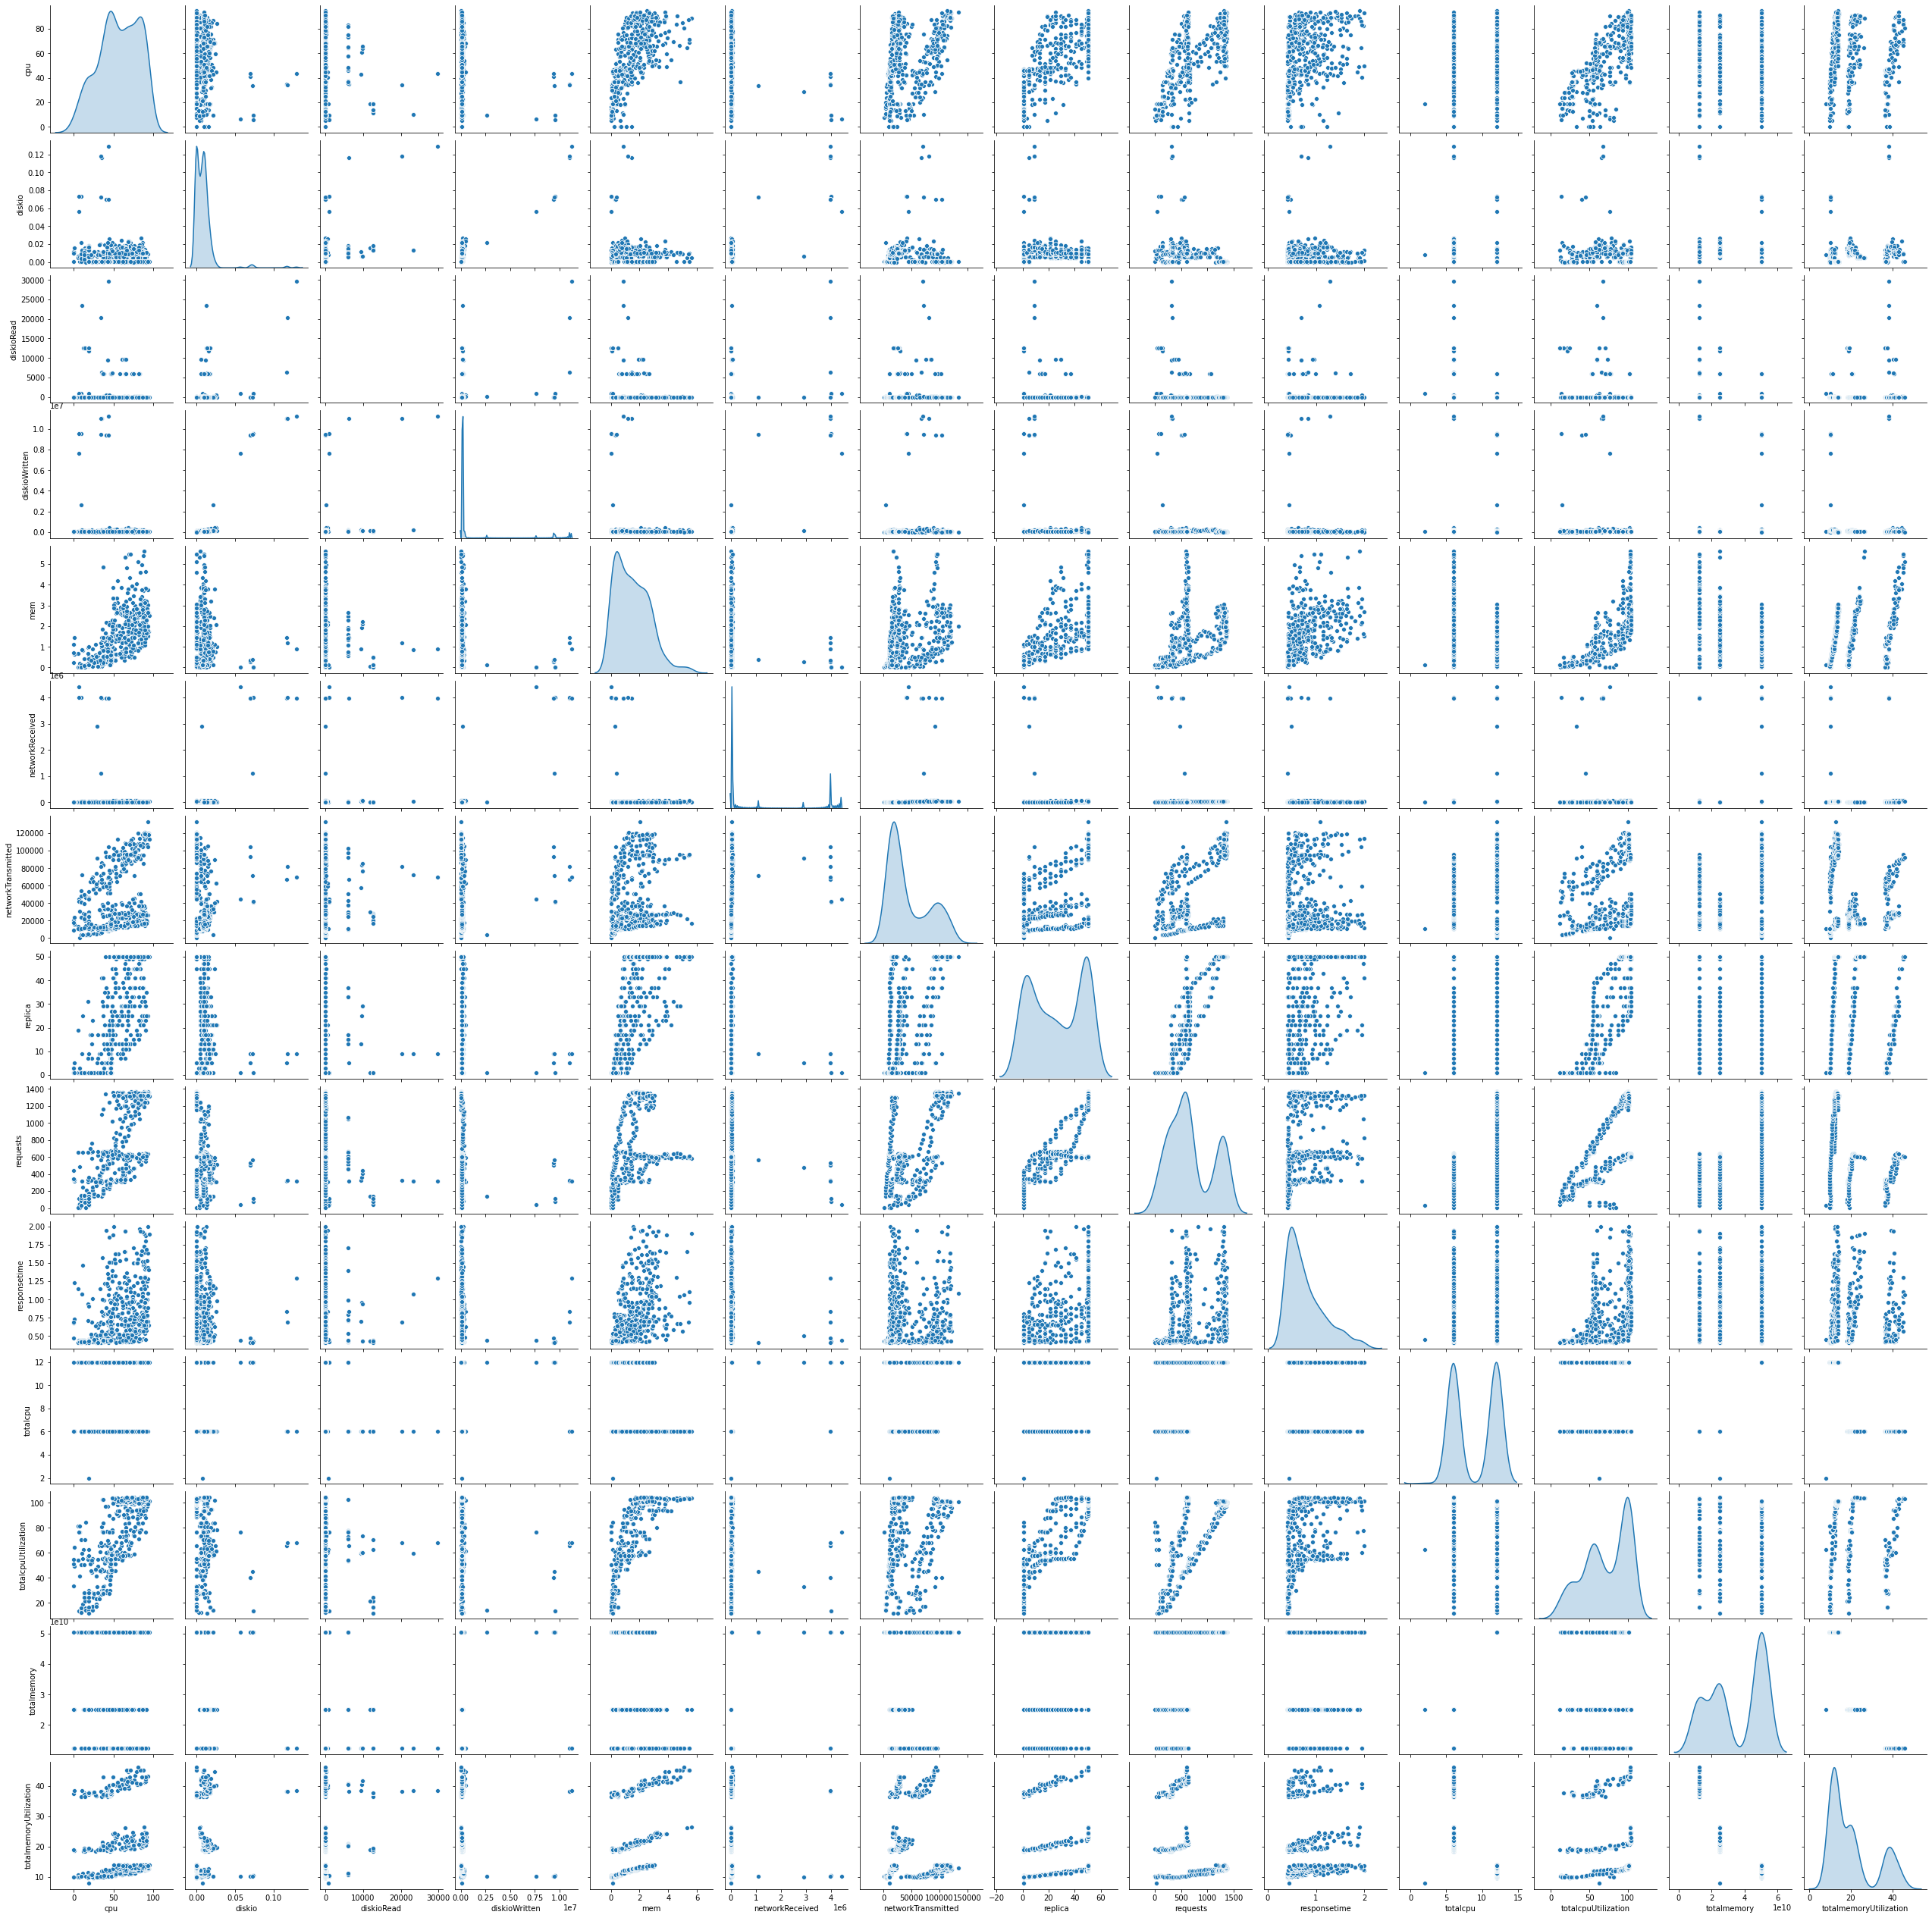

In [4]:
sns.pairplot(df, diag_kind='kde')

In [5]:
df_t = pd.DataFrame()
df_ttest = pd.DataFrame()

In [6]:
df_t['total_cpu_util'] = (df['totalcpuUtilization']*(df['totalcpu']*0.67))/100                    
df_t['total_mem_util'] = (df['totalmemoryUtilization']*df['totalmemory'])*1e-9
df_t['responsetime'] = df['responsetime']
df_t['requests'] = df['requests']
#df_t['replica'] = df['replica']
df_ttest['total_cpu_util'] = (df_test['totalcpuUtilization']*(df_test['totalcpu']*0.67))/100
df_ttest['total_mem_util'] = (df_test['totalmemoryUtilization']*df_test['totalmemory'])*1e-9
df_ttest['responsetime'] = df_test['responsetime']
df_ttest['requests'] = df_test['requests']
#df_ttest['replica'] = df_test['replica']
df_t.head()

,total_cpu_util,total_mem_util,responsetime,requests
0,6.137011,513.076211,0.427801,7.0
1,6.137011,513.076211,0.441701,42.0
2,1.062620,521.188136,0.429230,76.0
3,1.062620,521.188136,0.421655,112.0
4,1.142797,512.592066,0.439443,140.0


In [7]:
df_t.tail()

,total_cpu_util,total_mem_util,responsetime,requests
2791,4.195763,547.560653,0.974498,614.0
2792,4.197550,550.600704,0.758534,620.0
2794,4.197550,549.731942,0.703173,609.0
2795,4.197550,549.731942,1.361169,614.0
2796,4.201123,572.995584,1.039415,605.0


In [8]:
df_t = pd.get_dummies(df_t, prefix='', prefix_sep='')

In [9]:
df_t.shape

(475, 4)

In [10]:
train_dataset = df_t.sample(frac=0.8, random_state=0)
val_dataset = df_t.drop(train_dataset.index)
test_dataset = df_ttest

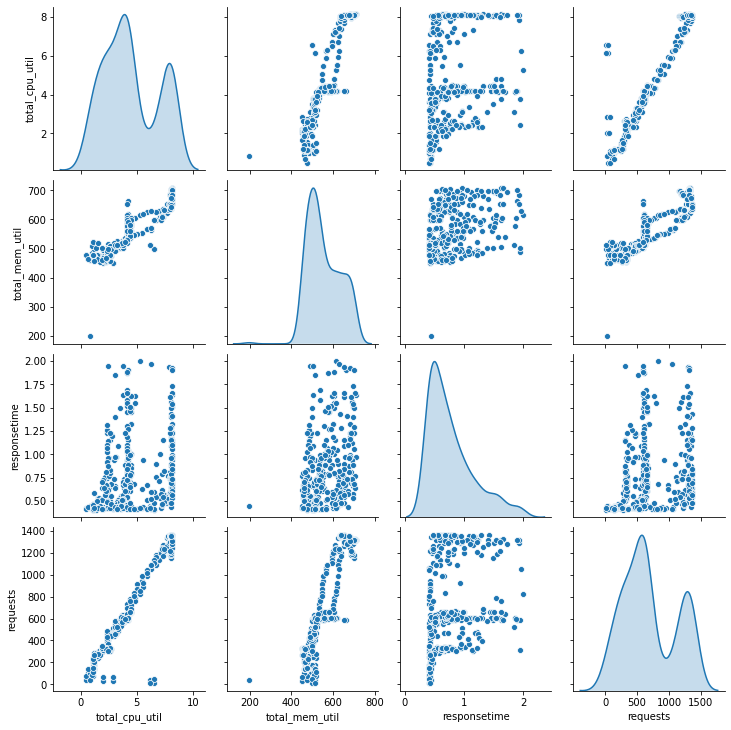

In [11]:
sns.pairplot(train_dataset[['total_cpu_util', 'total_mem_util', 'responsetime', 'requests']], diag_kind='kde')

In [12]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
total_cpu_util,380.0,4.459529,2.386795,0.471722,2.452200,4.153979,7.040974,8.145417
total_mem_util,380.0,556.740277,77.207620,198.466560,498.829973,536.228045,616.033536,708.841889
responsetime,380.0,0.785878,0.386621,0.404884,0.458702,0.671168,0.969647,1.996516
requests,380.0,695.765789,410.264392,7.000000,337.750000,607.000000,1166.250000,1365.000000


In [13]:
train_features = train_dataset.copy()
val_features = val_dataset.copy()
test_features = test_dataset.copy()

In [14]:
train_features.head()

,total_cpu_util,total_mem_util,responsetime,requests
956,7.107137,607.564807,0.999175,1195.0
509,4.189287,549.039514,0.852054,588.0
2305,1.123632,460.288819,0.442068,235.0
1872,3.823690,532.534270,0.640470,588.0
100,8.124643,694.475375,1.502266,1290.0


In [15]:
train_labels = train_features.pop('requests')
val_labels = val_features.pop('requests')
test_labels = test_features.pop('requests')

In [16]:
normalizer = preprocessing.Normalization()

In [17]:
normalizer.adapt(np.array(train_features))

In [18]:
print(normalizer.mean.numpy())

[  4.46  556.74    0.786]


## Linear Regression

In [19]:
input = np.array(train_features[['total_cpu_util', 'total_mem_util', 'responsetime']])

input_normalizer = preprocessing.Normalization(input_shape=[3,])
input_normalizer.adapt(input)

In [20]:
model = tf.keras.Sequential([
    input_normalizer,
    layers.Dense(units=1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 3)                 7         
_________________________________________________________________
dense (Dense)                (None, 1)                 4         
Total params: 11
Trainable params: 4
Non-trainable params: 7
_________________________________________________________________


In [21]:
model.predict(test_features)

array([[ 0.435],
       [ 0.645],
       [ 0.634],
       [ 1.252],
       [ 1.241],
       [ 1.338],
       [ 1.308],
       [ 1.286],
       [ 1.282],
       [ 1.171],
       [ 1.153],
       [ 1.001],
       [ 1.051],
       [ 0.861],
       [ 0.855],
       [ 0.851],
       [ 0.88 ],
       [ 0.615],
       [ 0.639],
       [ 0.302],
       [ 0.148],
       [ 0.263],
       [ 0.214],
       [-0.128],
       [-0.163],
       [-0.3  ],
       [-0.343],
       [-0.55 ],
       [-0.489],
       [-0.852],
       [-0.924],
       [-1.168],
       [-1.062],
       [-0.999],
       [-1.198],
       [-1.302],
       [-1.281],
       [-1.646],
       [-1.589],
       [-1.794],
       [-1.705],
       [-1.935],
       [-1.912],
       [-2.117],
       [-2.1  ],
       [-2.356],
       [-2.172],
       [-2.573],
       [-2.525],
       [-3.   ],
       [-2.917],
       [-2.946],
       [-3.243],
       [-2.914],
       [-3.15 ],
       [-3.356],
       [-3.136],
       [-3.059],
       [-3.27 

In [22]:
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [23]:
%%time
history = model.fit(
    train_features[['total_cpu_util', 'total_mem_util', 'responsetime']], train_labels,
    epochs=500,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 20.3 s, sys: 6.93 s, total: 27.2 s
Wall time: 19.6 s


In [24]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
495,227.663696,252.177200,495
496,226.844955,251.248169,496
497,225.996246,250.323654,497
498,225.153732,249.412567,498
499,224.311722,248.459595,499


In [25]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 800])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

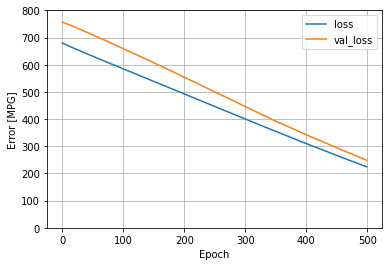

In [26]:
plot_loss(history)

In [27]:
test_results = {}

test_results['model'] = model.evaluate(
    val_features[['total_cpu_util', 'total_mem_util', 'responsetime']],
    val_labels, verbose=0)

In [28]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [29]:
dnn_model = build_and_compile_model(input_normalizer)

In [30]:
dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 3)                 7         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 4,488
Trainable params: 4,481
Non-trainable params: 7
_________________________________________________________________


In [31]:
%%time
history = dnn_model.fit(
    train_features[['total_cpu_util', 'total_mem_util', 'responsetime']], train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 4.96 s, sys: 1.49 s, total: 6.46 s
Wall time: 4.42 s


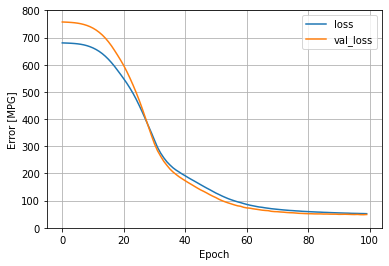

In [32]:
plot_loss(history)

In [33]:
test_results['dnn_model'] = dnn_model.evaluate(
    val_features[['total_cpu_util', 'total_mem_util', 'responsetime']], val_labels,
    verbose=0)

In [34]:
pd.DataFrame(test_results, index=['requests']).T

,requests
model,199.135010
dnn_model,47.256187


## Make Predictions

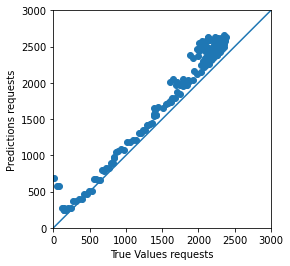

In [35]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values requests')
plt.ylabel('Predictions requests')
lims = [0, 3000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [36]:
from sklearn.metrics import r2_score
R = r2_score(test_labels, test_predictions)
print ('R² :',R)

R² : 0.8522577616743068


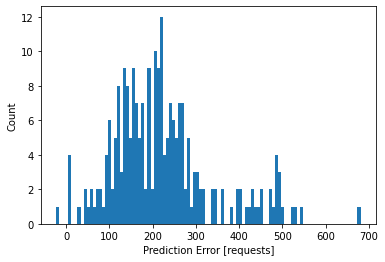

In [37]:
error = test_predictions - test_labels
plt.hist(error, bins=100)
plt.xlabel('Prediction Error [requests]')
_ = plt.ylabel('Count')